In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt

Sunday 10/21:

- Set deadlines for when certain things should be done by



Monday 10/22:

- Created the repository and the ReadMe



Sunday 10/28:

- Tried to figure out what we should do about dangling links when making the matrices (which occur when people produce a target that was never tested as a cue) 
- Decided on two options: 
1. a matrix that just ignores dangling links (and in the case of a stochstic matrix normalizes the remaining values to sum to 1)
2. a matrix with entries for the dangling links. We talked about just having no out-edges from nodes corresponding to the dangling links. But now I'm thinking we could just give them links to all other nodes (with weights uniformly distributed in the case of a stochastic matrix)

- I wrote the functions to create the matrices for the first option

- We also discussed what form to load in the data in. We decided on a dict mapping cues to targets, a list of the cues, and list of the unnormed targets.

Monday 10/29:

- Wrote methods to create the matrices (boolean and stochastic) for the second option from above. So the matrix has rows/cols for the dangling links, but right now these nodes have no out-going edges. 
- Immediate Next Step: we still have to decide what we'll do with dangling links and code it up

Wednesday 10/31:

- Decided to give the nodes corresponding to unnormed cues out-edges to all other nodes (all equally weighted in the case of the stocahstic matrix)
- Updated the createFullMatrix methods to reflect this decision
- Noticed that these unnormed nodes shouldn't have out-edges to themselves, so updated method to reflect this

Sunday 11/4:

- Discussed how to get the files storing the matrices to be small enough to be pushed to github
- Decided to just re-compute these matrices each time for now, since it only takes a few minutes and we weren't able to find an easy way of compressing the files further
- Checked to make sure the matrices being computed were correct
- Carefully read through the PageRank chapters of $\textit{Google's PageRank and Beyond: The Science of Search Engine Rankings}$ (https://muse.jhu.edu/book/36229/)
- Next Step: Begin Immplementing PageRank

Sunday 11/11:
    
- Wrote a function to load the two types of retrievability data. The K&F frequency is the frequency that words showd up in a text sample of about a million words, due to Kucera & Francis (1967). The accessibility index of a word x is the number of cues for which at leasrt 1 person produced x. 
- Wrote some tests below to make sure the dictionaries are actually being loaded correctly
- Realized that the Griffiths et al. paper doesn't have their full data set and that the K&F data is word frequency in text, not from a similar procedure to Griffiths et al.'s. This is concerning because we then don't anything to evaluate our models' performances against. Searched Grifiths's page and elsewhere on the internet for similar data sets (keyword: phonemic fluency task), but wasn't able to find any trials done on healthy adults. 
- Next Steps: Need to find a way of evaluating our models. Possibilites: 
    - Use the partial data in Griffiths paper, which only has 7 letters. It has the human frequencies for the top 10 words, and the frequencies for the top 10 words predicted by each model. 
    - Find some other dataset somewhere online
    - Run the experiment ourselves and gather our own data
    - Compare against some other metric besides the human production frequency (I hate this idea unless we can find something really closely related.)

In [2]:
import accessibility_loader

kf_frequencies, accessibility_indices = accessibility_loader.loadDicts()
#print("food:", kf_frequencies['food'], accessibility_indices['food'])
#print("money:", kf_frequencies['money'], accessibility_indices['money'])
#print("water:", kf_frequencies['water'], accessibility_indices['water'])

assert(kf_frequencies['night'] == 411)
assert(accessibility_indices['night'] == 55)

assert(kf_frequencies['bar'] == 82)
assert(accessibility_indices['bar'] == 46)

assert(kf_frequencies['fake'] == 10)
assert(accessibility_indices['fake'] == 46)

assert(kf_frequencies['grandparents'] == 3)
assert(accessibility_indices['grandparents'] == 2)

assert(kf_frequencies['man'] == 1207)
assert(accessibility_indices['man'] == 171)

assert(kf_frequencies.get('asdfasdf') == None)
assert(accessibility_indices.get('asdfasdfas') == None)
assert(kf_frequencies.get('devices') == None)
assert(kf_frequencies.get('peal') == None)


Monday 11/12:

- Went of office hours to talk the problem through with Anna. She suggested to use Griffiths partial data. She said we could run the experiment ourselves but she wouldn't recommend it unless we want to. Decided to run the experiment ourselves.  
- Created a google form to run the experiment (with Luna)
- After a trial on a few people, decided on the final experimental procedure: 
    - record name and gender
    - run through all the letters in a random order, twice
    - skipped the same letters as Griffiths et al. (K, Q, X, Y, Z)
    - "You're going to see a letter on the screen, and for each one, tell me first word starting with the letter than comes into your head."
    - Decided that any first word is ok, even if it is "inappropriate", a proper noun, or a repetition from teh first trial. However, non-English words are not allowed.
    - Let the participant read the letter off the screen so as not to confuse them. People kept thinking "eye" when I would say "I", "You" when I would say "U", etc. Zoom in to 500% in the browser so they participant can only see 1 letter at a time. 
    - When they say a word, I type it in and then tab to the next letter.
- Ran the experiment on roughly 25 people. 

Tuesday 11/13:

- Ran the experiment on roughly 5 more people to get to a total of 30 full trials 
- Thought about a couple of things we'll have to decide for cleaning the data: 
    - Do we count both entries if someone said the same thing in both trials?
    - Do we count the plural forms as the same as the singular? What about verb tenses? What about like apple and applesauce?
- Wrote code to load in the data from a CSV and put it into dictionaries. A dict maps each letter to another dict. Each of these dicts maps words (starting with that letter) to its frequency.
- Resolved this by just going through the preliminary dictionaries and deciding case-by-case which changes to make. The only changes we made were: 
    - inhibited to inhibit
    - lemons to lemon
    - males to male
    - rhino to rhinoceros
    - t-rex to tyrannosaurus
    - wins to win
    - (I made these changes by directly modifying the CSV)


## Load and Process Experimental Data:

In [3]:
import experimental_data_loader

frequencies = experimental_data_loader.load_data("data/ExperimentalData.csv")
tested_letters = ["A","B",'C','D','E','F','G','H','I','J','L','M','N','O','P','R','S','T','U','V','W']

for letter in tested_letters:
    print(sorted(frequencies[letter].items()))
    print("\n")

[('A', 1), ('AARDVARK', 1), ('ABERCROMBIE', 1), ('ACE', 1), ('AGGREGATE', 1), ('AIR', 1), ('ALBEIT', 1), ('ALEXANDER', 1), ('ALLEHANDRO', 1), ('ALLIGATOR', 1), ('ALPACCA', 1), ('ALPHABET', 9), ('AM', 1), ('AN', 1), ('AND', 1), ('ANDROGYNOUS', 1), ('ANGLE', 1), ('ANIMAL', 3), ('ANSWER', 6), ('ANT', 1), ('ANY', 1), ('ANYA', 1), ('APOSTROPHE', 1), ('APPLE', 14), ('APPLESAUCE', 2), ('ASSHOLE', 1), ('ATHLETE', 1), ('ATTACK', 1), ('ATTEMPT', 1), ('ATTRIBUTE', 1), ('AWESOME', 1)]


[('BABY', 2), ('BACHELOR', 1), ('BACK', 4), ('BAD', 1), ('BARBER', 1), ('BARELY', 1), ('BASEBALL', 1), ('BASKETBALL', 2), ('BASTARD', 1), ('BAT', 1), ('BATMAN', 1), ('BEAR', 2), ('BEAUTIFUL', 1), ('BECAUSE', 1), ('BEE', 3), ('BEGIN', 2), ('BELL', 2), ('BEN', 1), ('BERRY', 1), ('BIG', 1), ('BIRTHDAY', 2), ('BLACK', 2), ('BLUE', 1), ('BOAT', 2), ('BOB', 1), ('BOG', 1), ('BONITIS', 1), ('BONY', 1), ('BOOK', 5), ('BOTANIST', 1), ('BOY', 4), ('BRAG', 1), ('BRAIN', 2), ('BRING', 2), ('BROWN', 2), ('BUCK', 1), ('BUILDING'

Tuesday 11/13 (continued):

- Wrote the code below to sort each letter's dictionary by the values (frequencies)
- Wrote the code below to remove words that were only produced once
- Next Step: If we have time, write code to remove results that were produced only twice and both by the same person
    

In [4]:
ordered_frequencies = []
for letter in tested_letters:
    ordered_frequencies.append(sorted(frequencies[letter].items(), key=lambda x: x[1])[::-1])
    
for i in range(len(ordered_frequencies)):
    print("Most commonly produced words for " + tested_letters[i] + ":")
    for pair in ordered_frequencies[i]:
        print(pair[0]+ " ({0} times)".format(pair[1]))
    print("\n")

Most commonly produced words for A:
APPLE (14 times)
ALPHABET (9 times)
ANSWER (6 times)
ANIMAL (3 times)
APPLESAUCE (2 times)
ASSHOLE (1 times)
AND (1 times)
AWESOME (1 times)
ANDROGYNOUS (1 times)
ANT (1 times)
APOSTROPHE (1 times)
ALLEHANDRO (1 times)
ATTEMPT (1 times)
AM (1 times)
ALLIGATOR (1 times)
ANY (1 times)
ATHLETE (1 times)
A (1 times)
ANYA (1 times)
AIR (1 times)
ALBEIT (1 times)
ATTRIBUTE (1 times)
AGGREGATE (1 times)
ALPACCA (1 times)
ALEXANDER (1 times)
ABERCROMBIE (1 times)
ATTACK (1 times)
AN (1 times)
AARDVARK (1 times)
ANGLE (1 times)
ACE (1 times)


Most commonly produced words for B:
BOOK (5 times)
BACK (4 times)
BOY (4 times)
BEE (3 times)
BRING (2 times)
BROWN (2 times)
BABY (2 times)
BLACK (2 times)
BOAT (2 times)
BASKETBALL (2 times)
BRAIN (2 times)
BELL (2 times)
BEAR (2 times)
BEGIN (2 times)
BIRTHDAY (2 times)
BUCK (1 times)
BAT (1 times)
BACHELOR (1 times)
BEAUTIFUL (1 times)
BASEBALL (1 times)
BIG (1 times)
BONY (1 times)
BATMAN (1 times)
BECAUSE (1 times

In [5]:
ordered_frequencies_no_singles = []
#for letter_list in ordered_frequencies: 
#    ordered_frequencies_no_singles.append(item for item in letter_list if item[1] != 1)
for letter_list in ordered_frequencies:
    to_append = []
    for item in letter_list:
        if item[1] != 1:
            to_append.append(item)
    ordered_frequencies_no_singles.append(to_append)
    
    
for i in range(len(ordered_frequencies_no_singles)):
    print("Most commonly produced words for " + tested_letters[i] + " (singletons removed):")
    for pair in ordered_frequencies_no_singles[i]:
        print(pair[0]+ " ({0} times)".format(pair[1]))
    print("\n")

Most commonly produced words for A (singletons removed):
APPLE (14 times)
ALPHABET (9 times)
ANSWER (6 times)
ANIMAL (3 times)
APPLESAUCE (2 times)


Most commonly produced words for B (singletons removed):
BOOK (5 times)
BACK (4 times)
BOY (4 times)
BEE (3 times)
BRING (2 times)
BROWN (2 times)
BABY (2 times)
BLACK (2 times)
BOAT (2 times)
BASKETBALL (2 times)
BRAIN (2 times)
BELL (2 times)
BEAR (2 times)
BEGIN (2 times)
BIRTHDAY (2 times)


Most commonly produced words for C (singletons removed):
CAT (15 times)
CAR (3 times)
CUP (3 times)
CLAY (2 times)
CONTROLLER (2 times)
COLIN (2 times)
CLOSE (2 times)
COMPLEX (2 times)


Most commonly produced words for D (singletons removed):
DOG (16 times)
DICK (5 times)
DAD (3 times)
DANDELION (2 times)
DRAIN (2 times)
DINOSAUR (2 times)


Most commonly produced words for E (singletons removed):
ELEPHANT (17 times)
EAT (7 times)
EXPERIMENT (2 times)
EXPERIENCE (2 times)
ELEMENT (2 times)
EGO (2 times)
EDWARD (2 times)
EAR (2 times)
ENTER (2 ti

Tuesday 11/13 (continued):

- Wrote a new method to load the data but discount the second time a subject says the same word. (the previous Possible Next Step)
- Re-ran the two follow-up steps from above on the new dictionary. Code Below:

In [6]:
import experimental_data_loader

frequencies_no_repeats = experimental_data_loader.load_data_no_repeats("data/ExperimentalData.csv")
for letter in tested_letters:
    print(sorted(frequencies_no_repeats[letter].items()))
    print("\n")
    

[('A', 1), ('AARDVARK', 1), ('ABERCROMBIE', 1), ('ACE', 1), ('AGGREGATE', 1), ('AIR', 1), ('ALBEIT', 1), ('ALEXANDER', 1), ('ALLEHANDRO', 1), ('ALLIGATOR', 1), ('ALPACCA', 1), ('ALPHABET', 7), ('AM', 1), ('AN', 1), ('AND', 1), ('ANDROGYNOUS', 1), ('ANGLE', 1), ('ANIMAL', 3), ('ANSWER', 5), ('ANT', 1), ('ANY', 1), ('ANYA', 1), ('APOSTROPHE', 1), ('APPLE', 11), ('APPLESAUCE', 2), ('ASSHOLE', 1), ('ATHLETE', 1), ('ATTACK', 1), ('ATTEMPT', 1), ('ATTRIBUTE', 1), ('AWESOME', 1)]


[('BABY', 2), ('BACHELOR', 1), ('BACK', 3), ('BAD', 1), ('BARBER', 1), ('BARELY', 1), ('BASEBALL', 1), ('BASKETBALL', 2), ('BASTARD', 1), ('BAT', 1), ('BATMAN', 1), ('BEAR', 1), ('BEAUTIFUL', 1), ('BECAUSE', 1), ('BEE', 3), ('BEGIN', 1), ('BELL', 2), ('BEN', 1), ('BERRY', 1), ('BIG', 1), ('BIRTHDAY', 1), ('BLACK', 2), ('BLUE', 1), ('BOAT', 1), ('BOB', 1), ('BOG', 1), ('BONITIS', 1), ('BONY', 1), ('BOOK', 4), ('BOTANIST', 1), ('BOY', 3), ('BRAG', 1), ('BRAIN', 2), ('BRING', 1), ('BROWN', 2), ('BUCK', 1), ('BUILDING'

In [7]:
ordered_frequencies_no_repeats = []
for letter in tested_letters: 
    ordered_frequencies_no_repeats.append(sorted(frequencies_no_repeats[letter].items(), key=lambda x: x[1])[::-1])


for i in range(len(ordered_frequencies_no_repeats)):
    print("Most commonly produced words for " + tested_letters[i] + ":")
    for pair in ordered_frequencies_no_repeats[i]:
        print(pair[0]+ " ({0} times)".format(pair[1]))
    print("\n")

Most commonly produced words for A:
APPLE (11 times)
ALPHABET (7 times)
ANSWER (5 times)
ANIMAL (3 times)
APPLESAUCE (2 times)
ASSHOLE (1 times)
AND (1 times)
AWESOME (1 times)
ANDROGYNOUS (1 times)
ANT (1 times)
APOSTROPHE (1 times)
ALLEHANDRO (1 times)
ATTEMPT (1 times)
AM (1 times)
ALLIGATOR (1 times)
ANY (1 times)
ATHLETE (1 times)
A (1 times)
ANYA (1 times)
AIR (1 times)
ALBEIT (1 times)
ATTRIBUTE (1 times)
AGGREGATE (1 times)
ALPACCA (1 times)
ALEXANDER (1 times)
ABERCROMBIE (1 times)
ATTACK (1 times)
AN (1 times)
AARDVARK (1 times)
ANGLE (1 times)
ACE (1 times)


Most commonly produced words for B:
BOOK (4 times)
BEE (3 times)
BACK (3 times)
BOY (3 times)
BROWN (2 times)
BABY (2 times)
BLACK (2 times)
BASKETBALL (2 times)
BRAIN (2 times)
BELL (2 times)
BUCK (1 times)
BAT (1 times)
BACHELOR (1 times)
BEAUTIFUL (1 times)
BASEBALL (1 times)
BIG (1 times)
BONY (1 times)
BRING (1 times)
BATMAN (1 times)
BECAUSE (1 times)
BARBER (1 times)
BLUE (1 times)
BOB (1 times)
BAD (1 times)
BAS

In [8]:
ordered_frequencies_no_repeats_no_singles = []
for letter_list in ordered_frequencies_no_repeats:
    to_append = []
    for item in letter_list:
        if item[1] != 1:
            to_append.append(item)
    ordered_frequencies_no_repeats_no_singles.append(to_append)
    
for i in range(len(ordered_frequencies_no_repeats_no_singles)):
    print("Most commonly produced words for " + tested_letters[i] + " (singletons removed):")
    for pair in ordered_frequencies_no_repeats_no_singles[i]:
        print(pair[0]+ " ({0} times)".format(pair[1]))
    print("\n")
    
count = 0
for l in ordered_frequencies_no_repeats_no_singles:
    count += len(l)
print(count)

Most commonly produced words for A (singletons removed):
APPLE (11 times)
ALPHABET (7 times)
ANSWER (5 times)
ANIMAL (3 times)
APPLESAUCE (2 times)


Most commonly produced words for B (singletons removed):
BOOK (4 times)
BEE (3 times)
BACK (3 times)
BOY (3 times)
BROWN (2 times)
BABY (2 times)
BLACK (2 times)
BASKETBALL (2 times)
BRAIN (2 times)
BELL (2 times)


Most commonly produced words for C (singletons removed):
CAT (11 times)
CUP (3 times)
CAR (2 times)


Most commonly produced words for D (singletons removed):
DOG (11 times)
DICK (5 times)
DAD (2 times)
DANDELION (2 times)
DRAIN (2 times)
DINOSAUR (2 times)


Most commonly produced words for E (singletons removed):
ELEPHANT (12 times)
EAT (5 times)
EXPERIENCE (2 times)
EAR (2 times)


Most commonly produced words for F (singletons removed):
FUCK (8 times)
FRIEND (3 times)
FIVE (2 times)
FLUENCY (2 times)
FROG (2 times)
FAT (2 times)
FLOWER (2 times)


Most commonly produced words for G (singletons removed):
GREAT (5 times)
GOD

In [9]:
with open('lib/top_words.pickle', 'wb') as f:
    pickle.dump(ordered_frequencies_no_singles, f)
    
with open('lib/top_words_no_repeats.pickle', 'wb') as f:
    pickle.dump(ordered_frequencies_no_repeats_no_singles, f)
    

Tuesday 11/13 (continued):

- Next Steps: If time, get the pickles above to work
- Create code to evaluate the hits and pagerank models against the most popular responses above

- Wrote the code below to load in the the data from the rankings
- Wrote the bode below that, creating dicts for each model that map letters to lists. Each list has the words starting with that letter, ordered by importance according to the model. This will be very useful for evaluating the models. 

## Model Evaluation and Visualization:

In [10]:
# Load in the data from the experiment we ran

with open('lib/top_words.pickle', 'rb') as f:
    top_words = pickle.load(f)
    
with open('lib/top_words_no_repeats.pickle', 'rb') as f:
    top_words_no_repeats = pickle.load(f)

In [11]:
#Load in data from models
'''
f = open("lib/pageRankRankings.pickle", 'r')
page_rank_rankings = pickle.load(f)

f = open("lib/hitsAuthRankings.pickle", 'r')
hits_auth_rankings = pickle.load(f)

f = open("lib/hitsHubRankings.pickle", 'r')
hits_hub_rankings = pickle.load(f)

f = open("lib/normedItems.pickle", 'r')
normed_list = pickle.load(f)

f = open("lib/unnormedItems.pickle", 'r')
unnormed_list = pickle.load(f)
'''
page_rank_rankings = np.load("lib/pageRankRankings.pickle")
hits_auth_rankings = np.load("lib/hitsAuthRankings.pickle")
hits_hub_rankings = np.load("lib/hitsHubRankings.pickle")
normed_list = np.load("lib/normedItems.pickle")
unnormed_list = np.load("lib/unnormedItems.pickle")

all_indices = np.append(normed_list, unnormed_list)

# each of the np (1-d) ndarrays below contains lists of indices in order of importance according to the relevant model
# the values stored in the array correspond to indices in all_indices
page_rank_ordered = np.argsort(page_rank_rankings)[::-1]
hits_auth_ordered = np.argsort(hits_auth_rankings)[::-1]
hits_hub_ordered = np.argsort(hits_hub_rankings)[::-1]

Tuesday 11/13 (continued):

Next Step:

For each model and each letter, we have a list of the words starting with that letter, ordered by importance accoring to the model. Additionally, we have the experimental data in a useable format: for each letter we used as a cue, we have an ordered list of those words that were produced by multiple partipants, in order of frequency. However, this data able to be printed but not accessed otherwise due to reasons (relating to generators I think) that I don't understand. Assuming the data is accessible, we simply need to loop through the words in the experimental production data and find the importance ranking that each model gave to that word (normalized for the total number of words starting with that letter). The aggregate of these scores is how Griffiths et al. evaluated their model. 

Wednesday 11/14:

- Edited the code above to turn all the generators into regular lists by just ripping out the code and writing it with vanilla for loops. I'm still not really sure why those were generators and not just list comprehension, but everything seeems to be working now. In particular, we have two lists of lists (top_words and top_words_no_repeats). There is one outer list for each letter we ran the experiment on. The inner lists contain tuples of words the participants prduced and their frequencies, ordered by frequency. Neither list contains words that only showed up once. The second list only counts a word once if a single participant produced it twice. 
- Now that the lists are working, it was trivial to get the pickle code to work as well. 
- Wrote the code below. For each word the participants in the experiment produced multiple times, it prints out the ranking that each of the 3 measures gave to that the word (or N/A if it wasn't in the semantic network)

In [12]:
page_rank_ordered_list = np.ndarray.tolist(page_rank_ordered)
hits_auth_ordered_list = np.ndarray.tolist(hits_auth_ordered)
hits_hub_ordered_list = np.ndarray.tolist(hits_hub_ordered)
indices_list = np.ndarray.tolist(all_indices)

results = []
for letter_index in range(len(tested_letters)):
    letter_results = []
    letter = tested_letters[letter_index]
    target_words = top_words_no_repeats[letter_index]
    
    for target, freq in target_words:
        target_results = [target]
        if target in indices_list:
            target_index = indices_list.index(target)
            target_results.append(page_rank_ordered_list.index(target_index))
            target_results.append(hits_auth_ordered_list.index(target_index))
            target_results.append(hits_hub_ordered_list.index(target_index))
        else: 
            target_results += (["N/A", "N/A", "N/A"])
        letter_results.append(target_results)
    results.append(letter_results)

for letter_result in results:
    print("\nTarget Word, PageRank, AuthScore, HubScore")
    for word_result in letter_result:
        print(word_result)
    


Target Word, PageRank, AuthScore, HubScore
['APPLE', 188, 274, 6991]
['ALPHABET', 1508, 2466, 9419]
['ANSWER', 264, 192, 9817]
['ANIMAL', 23, 20, 5621]
['APPLESAUCE', 'N/A', 'N/A', 'N/A']

Target Word, PageRank, AuthScore, HubScore
['BOOK', 41, 19, 7704]
['BEE', 921, 1098, 10281]
['BACK', 205, 256, 8844]
['BOY', 32, 209, 9446]
['BROWN', 423, 387, 6221]
['BABY', 97, 76, 6465]
['BLACK', 25, 26, 9448]
['BASKETBALL', 484, 414, 8631]
['BRAIN', 307, 329, 7078]
['BELL', 509, 1024, 9265]

Target Word, PageRank, AuthScore, HubScore
['CAT', 43, 150, 10591]
['CUP', 399, 402, 9486]
['CAR', 12, 5, 5713]

Target Word, PageRank, AuthScore, HubScore
['DOG', 3, 22, 10448]
['DICK', 3101, 5041, 5575]
['DAD', 459, 721, 10485]
['DANDELION', 5753, 4684, 10313]
['DRAIN', 2071, 1724, 6524]
['DINOSAUR', 3975, 2329, 6411]

Target Word, PageRank, AuthScore, HubScore
['ELEPHANT', 507, 1173, 6450]
['EAT', 36, 34, 9251]
['EXPERIENCE', 3798, 1977, 6517]
['EAR', 420, 847, 8196]

Target Word, PageRank, AuthScore, Hub

In [13]:
# count the number of words in the semantic network starting with each letter
count_by_letter = [0 for i in range(len(tested_letters))]
for word in np.nditer(all_indices):
    word = str(word)
    if word[0] in tested_letters:
        index = tested_letters.index(word[0])
        count_by_letter[index] += 1
    
print(count_by_letter)

[603, 694, 1055, 652, 374, 481, 350, 417, 347, 128, 348, 541, 239, 260, 817, 548, 1263, 586, 207, 160, 295]


In [14]:
# For each of the 3 models, get 1 list for each letter that was tested
# Each list has the words starting with that letter, ordered by importance according to the model

#page_rank_by_letter = {letter: [] for letter in tested_letters}
page_rank_by_letter = {}
for letter in tested_letters:
    page_rank_by_letter[letter] = []
for index in page_rank_ordered:
    word = all_indices[index]
    if (word[0]) in tested_letters:
        page_rank_by_letter[word[0]].append(str(word))
        
#hits_auth_by_letter = {letter: [] for letter in tested_letters}
hits_auth_by_letter = {}
for letter in tested_letters:
    hits_auth_by_letter[letter] = []
for index in hits_auth_ordered:
    word = all_indices[index]
    if (word[0]) in tested_letters:
        hits_auth_by_letter[word[0]].append(str(word))
        
#hits_hub_by_letter = {letter: [] for letter in tested_letters}
hits_hub_by_letter = {}
for letter in tested_letters:
    hits_hub_by_letter[letter] = []
for index in hits_hub_ordered:
    word = all_indices[index]
    if (word[0]) in tested_letters:
        hits_hub_by_letter[word[0]].append(str(word))

In [15]:
# For each word produced in the experiment
# Print the score each model assigns to it as a percentile of the words starting with the same letter

percentile_results = []
for letter_index in range(len(tested_letters)):
    letter_results = []
    letter = tested_letters[letter_index]
    page_rank_list = page_rank_by_letter[letter] 
    hits_auth_list = hits_auth_by_letter[letter] 
    hits_hub_list = hits_hub_by_letter[letter] 
    
    target_words = top_words_no_repeats[letter_index]    
    for target, freq in target_words:
        target_results = [target]
        if target in indices_list:
            target_results.append((page_rank_list.index(target)+1) / float(count_by_letter[letter_index]))
            target_results.append((hits_auth_list.index(target)+1) / float(count_by_letter[letter_index]))
            target_results.append((hits_hub_list.index(target)+1) / float(count_by_letter[letter_index]))
        else: 
            target_results += (["N/A", "N/A", "N/A"])
        letter_results.append(target_results)
    percentile_results.append(letter_results)
    
for letter_result in percentile_results:
    print("\nTarget Word, PageRank, AuthScore, HubScore")
    for word_result in letter_result:
        print(word_result)


Target Word, PageRank, AuthScore, HubScore
['APPLE', 0.006633499170812604, 0.013266998341625208, 0.6849087893864013]
['ALPHABET', 0.12603648424543948, 0.2222222222222222, 0.8855721393034826]
['ANSWER', 0.011608623548922056, 0.009950248756218905, 0.9270315091210614]
['ANIMAL', 0.001658374792703151, 0.001658374792703151, 0.5572139303482587]
['APPLESAUCE', 'N/A', 'N/A', 'N/A']

Target Word, PageRank, AuthScore, HubScore
['BOOK', 0.007204610951008645, 0.002881844380403458, 0.7190201729106628]
['BEE', 0.10806916426512968, 0.12680115273775217, 0.962536023054755]
['BACK', 0.0345821325648415, 0.03170028818443804, 0.8371757925072046]
['BOY', 0.005763688760806916, 0.025936599423631124, 0.8847262247838616]
['BROWN', 0.05475504322766571, 0.04610951008645533, 0.5778097982708934]
['BABY', 0.01440922190201729, 0.011527377521613832, 0.6138328530259366]
['BLACK', 0.004322766570605188, 0.004322766570605188, 0.8861671469740634]
['BASKETBALL', 0.06051873198847262, 0.05187319884726225, 0.8198847262247838]

['SAD', 0.0023752969121140144, 0.004750593824228029, 0.9667458432304038]

Target Word, PageRank, AuthScore, HubScore
['TRAIN', 0.02218430034129693, 0.040955631399317405, 0.5853242320819113]
['TEA', 0.09385665529010238, 0.09726962457337884, 0.8600682593856656]
['TIME', 0.0017064846416382253, 0.0017064846416382253, 0.726962457337884]
['TREE', 0.0034129692832764505, 0.0034129692832764505, 0.5409556313993175]
['TOTALLY', 'N/A', 'N/A', 'N/A']
['TYRANNOSAURUS', 0.8959044368600683, 0.7320819112627986, 0.2781569965870307]

Target Word, PageRank, AuthScore, HubScore
['UNDER', 0.014492753623188406, 0.05314009661835749, 0.9371980676328503]
['UMBRELLA', 0.13043478260869565, 0.19806763285024154, 0.9758454106280193]
['USURP', 1.0, 0.2995169082125604, 1.0]
['UNICORN', 0.3188405797101449, 0.2608695652173913, 0.8309178743961353]
['ULYSSES', 0.7777777777777778, 0.9420289855072463, 0.06280193236714976]
['UP', 0.004830917874396135, 0.004830917874396135, 0.9903381642512077]
['URANUS', 0.27053140096618356, 

In [16]:
# Create a list of the percentiles that each model assigned to human responses
# Print the Medians 

page_rank_percentiles= []
hits_auth_percentiles= []
hits_hub_percentiles= []

for letter_index in range(len(tested_letters)):
    letter = tested_letters[letter_index]
    page_rank_list = page_rank_by_letter[letter] 
    hits_auth_list = hits_auth_by_letter[letter] 
    hits_hub_list = hits_hub_by_letter[letter] 
    
    target_words = top_words_no_repeats[letter_index]    
    for target, freq in target_words:
        if target in indices_list:
            page_rank_percentiles.append((page_rank_list.index(target)+1) / float(count_by_letter[letter_index]))
            hits_auth_percentiles.append((hits_auth_list.index(target)+1) / float(count_by_letter[letter_index]))
            hits_hub_percentiles.append((hits_hub_list.index(target)+1) / float(count_by_letter[letter_index]))
    
page_rank_percentiles = sorted(page_rank_percentiles)
hits_auth_percentiles = sorted(hits_auth_percentiles)
hits_hub_percentiles = sorted(hits_hub_percentiles)

print("PageRank Median Percentile:", page_rank_percentiles[len(page_rank_percentiles)// 2])
print("HITS Authority Median Percentile:", hits_auth_percentiles[len(hits_auth_percentiles)//2])
print("HITS Hub Median Percentile:",hits_hub_percentiles[len(hits_hub_percentiles)//2])

PageRank Median Percentile: 0.05275779376498801
HITS Authority Median Percentile: 0.05747126436781609
HITS Hub Median Percentile: 0.7943696450428397


In [17]:
# Pickle the data

with open('page_rank_percentiles.pickle', 'wb') as f:
    pickle.dump(page_rank_percentiles, f)
    
with open('hits_auth_percentiles.pickle', 'wb') as f:
    pickle.dump(hits_auth_percentiles, f)
    
with open('hits_hub_percentiles.pickle', 'wb') as f:
    pickle.dump(hits_hub_percentiles, f)

with open('percentile_results.pickle', 'wb') as f:
    pickle.dump(percentile_results, f)


In [19]:
'''
f = open("lib/pageRankRankings.pickle", 'r')
page_rank_rankings = pickle.load(f)

f = open("lib/hitsAuthRankings.pickle", 'r')
hits_auth_rankings = pickle.load(f)

f = open("lib/hitsHubRankings.pickle", 'r')
hits_hub_rankings = pickle.load(f)

f = open("lib/normedItems.pickle", 'r')
normed_list = pickle.load(f)

f = open("lib/unnormedItems.pickle", 'r')
unnormed_list = pickle.load(f)
'''

'\nf = open("lib/pageRankRankings.pickle", \'r\')\npage_rank_rankings = pickle.load(f)\n\nf = open("lib/hitsAuthRankings.pickle", \'r\')\nhits_auth_rankings = pickle.load(f)\n\nf = open("lib/hitsHubRankings.pickle", \'r\')\nhits_hub_rankings = pickle.load(f)\n\nf = open("lib/normedItems.pickle", \'r\')\nnormed_list = pickle.load(f)\n\nf = open("lib/unnormedItems.pickle", \'r\')\nunnormed_list = pickle.load(f)\n'

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_size_inches'

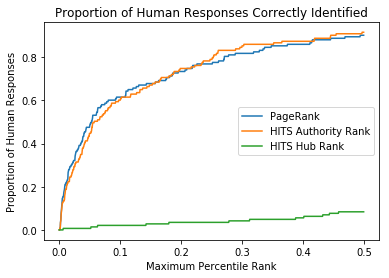

In [95]:
x_axis = []
for i in range(1000):
    x_axis.append(i / 2000)

page_rank_y = []
auth_y = []
hub_y = []
for x in x_axis:
    pr_max = 0
    while pr_max < len(page_rank_percentiles) and page_rank_percentiles[pr_max] < x:
        pr_max += 1
    page_rank_y.append(pr_max / len(page_rank_percentiles))
    
    auth_max = 0
    while auth_max < len(hits_auth_percentiles) and hits_auth_percentiles[auth_max] < x :
        auth_max += 1
    auth_y.append(auth_max / len(hits_auth_percentiles))
    
    hub_max = 0
    while hub_max < len(hits_hub_percentiles) and hits_hub_percentiles[hub_max] < x:
        hub_max += 1
    hub_y.append(hub_max / len(hits_hub_percentiles))

plt.plot(x_axis, page_rank_y, label="PageRank")
plt.plot(x_axis, auth_y, label='HITS Authority Rank')
plt.plot(x_axis, hub_y, label='HITS Hub Rank')
plt.xlabel("Maximum Percentile Rank")
plt.ylabel("Proportion of Human Responses")
plt.title("Proportion of Human Responses Correctly Identified")
plt.legend()
plt.show()

# This shows the proportion of human responses that each model correctly identified to a given accuracy
# In other words, for a particular percentile x, the y axis shows the proportion of the human responses that
# the model ranked as x or lower. (A low percentile indicates a high probability of being produced.)

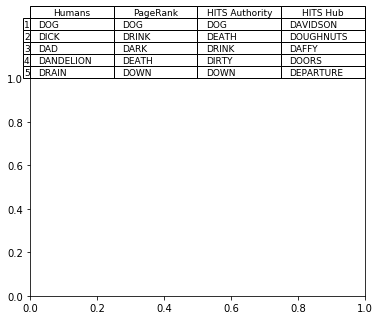

In [94]:
humans_by_letter = ordered_frequencies_no_repeats
page_rank_by_letter
hits_auth_by_letter
hits_hub_by_letter
tested_letters

for letter in ['D']:
    humans = humans_by_letter[tested_letters.index(letter)][0:5] 
    for i in range(len(humans)):
        humans[i] = humans[i][0]
        
    top_5 = np.array([humans, 
                       page_rank_by_letter[letter][0:5], 
                       hits_auth_by_letter[letter][0:5], 
                       hits_hub_by_letter[letter][0:5] ])
    top_5 = top_5.transpose()
    plt.table(cellText=top_5, loc='top', rowLabels=[1,2,3,4,5], colLabels=["Humans", "PageRank", "HITS Authority", "HITS Hub"], cellLoc='left')
